# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [143]:
# Data manipulation
import pandas as pd
import numpy as np
from glob import glob
import math

# Options for pandas
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 600
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
# Set default font size
plt.rcParams['font.size'] = 24
import seaborn as sb
# Set default font size
sb.set(font_scale = 1)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)


# Interactive Visualizations
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)

# import cufflinks as cf
# cf.go_offline(connected=True)
# icf.set_config_file(theme='white')

# Analysis/Modeling
Do work here

In [144]:
filenames = glob('data/Right_Pip_Results1/*.tsv')
dependency_df = pd.concat(
    [pd.read_csv(f, sep="\t", header=0) for f in filenames])
filename = "data/TableS2C.csv"
# load full dataset of variants (rare & non-rare) 
variant_data = pd.read_csv(filename, sep=",", skiprows=20)
variant_data["hgvs"] = variant_data[['Transcript', 'cDNA']].agg(
    ':'.join, axis=1).values

# expand variants (e.g. var1 | var 2), one per row
gb = dependency_df[["GENE", "var","ctype", 'medFitEff', 'rank_ratio']].groupby(["GENE", 
                    "ctype", 'medFitEff', 'rank_ratio'])
arr = []
for name, group in gb:
    GENE,ctype,medFitEff,rank_ratio = name
    l = group["var"].astype(str).apply(
        lambda x: x.split(" | ")).values[0]
    for e in l:
        arr.append([GENE,ctype,medFitEff,rank_ratio,e])
dependency_df = pd.DataFrame(arr, columns=["GENE", "ctype", 'medFitEff', 'rank_ratio', "var"])
dependency_df = pd.merge(variant_data, dependency_df, left_on=["Gene", "AA"],
                         right_on=["GENE", "var"], how="right")

dependency_df.COSMIC_ID = dependency_df.COSMIC_ID.astype(int).astype(str)

# add bool col for gene essentiality filter
medFitEff_max = -.5
rank_ratio_max = 1.2
dependency_df["essentiality_annot"] = (dependency_df["medFitEff"] < medFitEff_max) &\
    (dependency_df["rank_ratio"] < rank_ratio_max)

# load VEP data from ensembl VEP
vep_data = pd.read_csv("data/significant_vep_data_hgvs_clean.tsv",
                       sep="\t", index_col=0)
dependency_vep_df = pd.merge(vep_data, dependency_df,
                             left_on="id",
                             right_on="hgvs",
                             how="right")

# add bool col for probable deleterious variants
impact_keep = ["MODERATE"]
poly_keep = ["probably_damaging", "possibly_damaging", "nan"]
sift_keep = ["deleterious", "nan"]
dependency_vep_df["vep_annot"] = dependency_vep_df.eval("(impact in @impact_keep &\
polyphen_prediction in @poly_keep \
& sift_prediction in @sift_keep) | (impact == 'HIGH')")
dependency_vep_df = dependency_vep_df[["var", "hgvs", "COSMIC_ID", "GENE", 'Transcript', "ctype",
                                       'essentiality_annot', 'vep_annot',
                                       'impact', 'consequence_terms',
                                       'cadd_raw', 'cadd_phred',
                                       'polyphen_prediction', 'sift_prediction',
                                       'medFitEff', 'rank_ratio']].drop_duplicates()

# add drug-target info from Goncalves et al 2020
target_data = pd.read_csv("data/full_gene-target_annot.tsv", sep="\t")
dependency_vep_target_df = pd.merge(target_data, dependency_vep_df,
                                    left_on="target_ENST_id",
                                    right_on="Transcript",
                                    how="right")
dependency_vep_target_df = dependency_vep_target_df.rename(
    columns={"Name": "DRUG_NAME_target"})
# add bool col for target annotation (aka is there a drug that targets the variant's gene?)
dependency_vep_target_df["drug-gene_annot"] = dependency_vep_target_df.DRUG_NAME_target.notna()

#load response data(IC50) from GDSC1 & GDSC2
GDSC_response_data = pd.concat([pd.read_csv("data/GDSC1_fitted_dose_response_25Feb20.csv"),
                                pd.read_csv("data/GDSC2_fitted_dose_response_25Feb20.csv")]).drop_duplicates()
GDSC_response_data = GDSC_response_data.rename(
    columns={"DRUG_NAME": "DRUG_NAME_response"})

GDSC_response_data.COSMIC_ID = GDSC_response_data.COSMIC_ID.astype(int).astype(str)

# add drug response info
dependency_vep_target_response_df = pd.merge(dependency_vep_target_df, GDSC_response_data,
                                             left_on=["COSMIC_ID",
                                                      "DRUG_NAME_target"],
                                             right_on=["COSMIC_ID",
                                                       "DRUG_NAME_response"],
                                             how="left").drop_duplicates()
# check if cell_line;drug in GDSC
dependency_vep_target_response_df["drug_cell_in_GDSC"] = dependency_vep_target_response_df.DRUG_NAME_response.notna()
dependency_vep_target_response_df["IC50"] = dependency_vep_target_response_df["LN_IC50"].astype(float).\
    apply(lambda x: math.exp(x))
# check if IC50<max_c
dependency_vep_target_response_df["IC50<MAX_CONC"] = dependency_vep_target_response_df.IC50 < \
dependency_vep_target_response_df.MAX_CONC

# pick the best (<IC50) drug for each variant 
all_filters_df = dependency_vep_target_response_df[(dependency_vep_target_response_df.essentiality_annot == True) & \
                                 (dependency_vep_target_response_df.vep_annot == True) & \
                                 (dependency_vep_target_response_df["drug-gene_annot"] == True) & \
                                 (dependency_vep_target_response_df.drug_cell_in_GDSC == True) & \
                                 (dependency_vep_target_response_df["IC50<MAX_CONC"] == True)].sort_values('IC50').\
groupby(["COSMIC_ID", 'hgvs']).head(1).drop_duplicates()

dependency_vep_target_response_df["best_drug_for_var"] = \
[True if x in all_filters_df.index else False for x in dependency_vep_target_response_df.index]

dependency_vep_target_response_df

Drug ID DRUG_NAME_target Synonyms Drug Type Pathway Chembl  MW  \
0           NaN              NaN      NaN       NaN     NaN    NaN NaN   
1           NaN              NaN      NaN       NaN     NaN    NaN NaN   
2           NaN              NaN      NaN       NaN     NaN    NaN NaN   
3           NaN              NaN      NaN       NaN     NaN    NaN NaN   
4           NaN              NaN      NaN       NaN     NaN    NaN NaN   
...         ...              ...      ...       ...     ...    ...  ..   
202847      NaN              NaN      NaN       NaN     NaN    NaN NaN   
202848      NaN              NaN      NaN       NaN     NaN    NaN NaN   
202849      NaN              NaN      NaN       NaN     NaN    NaN NaN   
202850      NaN              NaN      NaN       NaN     NaN    NaN NaN   
202851      NaN              NaN      NaN       NaN     NaN    NaN NaN   

       Gene Target target_ENSG_id target_ENST_id         var  \
0              NaN            NaN            NaN     p.D486N   
1              NaN            NaN            NaN  p.P41fs*33   
2              NaN            NaN            NaN      p.R90H   
3              NaN            NaN            NaN         p.?   
4              NaN            NaN            NaN      p.S98F   
...            ...            ...            ...         ...   
202847         NaN            NaN            NaN     p.I262T   
202848         NaN            NaN            NaN     p.E774D   
202849         NaN            NaN            NaN     p.S744P   
202850         NaN            NaN            NaN     p.C286Y   
202851         NaN            NaN            NaN     p.C286Y   

                                 hgvs COSMIC_ID  GENE       Transcript  \
0           ENST00000263100:c.1456G>A    907289  A1BG  ENST00000263100   
1       ENST00000263100:c.121_122insA    909761  A1BG  ENST00000263100   
2            ENST00000263100:c.269G>A    909698  A1BG  ENST00000263100   
3           ENST00000263100:c.35-2A>G   1240174  A1BG  ENST00000263100   
4            ENST00000263100:c.293C>T   1298151  A1BG  ENST00000263100   
...                               ...       ...   ...              ...   
202847       ENST00000370801:c.785T>C    724859  ZZZ3  ENST00000370801   
202848      ENST00000370801:c.2322A>C    909708  ZZZ3  ENST00000370801   
202849      ENST00000370801:c.2230T>C    909257  ZZZ3  ENST00000370801   
202850       ENST00000370801:c.857G>A    909740  ZZZ3  ENST00000370801   
202851       ENST00000370801:c.857G>A   1295741  ZZZ3  ENST00000370801   

                                ctype  essentiality_annot  vep_annot impact  \
0                Colorectal Carcinoma               False      False    NaN   
1                Colorectal Carcinoma               False      False    NaN   
2                Colorectal Carcinoma               False      False    NaN   
3               Endometrial Carcinoma               False      False    NaN   
4            Hepatocellular Carcinoma               False      False    NaN   
...                               ...                 ...        ...    ...   
202847  Non-Small Cell Lung Carcinoma               False      False    NaN   
202848          Oral Cavity Carcinoma               False      False    NaN   
202849              Ovarian Carcinoma               False      False    NaN   
202850            Plasma Cell Myeloma               False      False    NaN   
202851            Plasma Cell Myeloma               False      False    NaN   

       consequence_terms  cadd_raw  cadd_phred polyphen_prediction  \
0                    NaN       NaN         NaN                 NaN   
1                    NaN       NaN         NaN                 NaN   
2                    NaN       NaN         NaN                 NaN   
3                    NaN       NaN         NaN                 NaN   
4                    NaN       NaN         NaN                 NaN   
...                  ...       ...         ...                 ...   
202847               N

In [145]:
dependency_vep_target_response_df = dependency_vep_target_response_df[["var", "hgvs", "COSMIC_ID", "CELL_LINE_NAME",
                                                                       "GENE", "ctype", "DRUG_NAME_response", "Transcript",
                                                                       'essentiality_annot',
                                                                       'vep_annot', "drug-gene_annot", 
                                                                       "drug_cell_in_GDSC",
                                                                       "IC50<MAX_CONC", "best_drug_for_var",
                                                                       'impact', 'consequence_terms',
                                                                       'cadd_phred', 'polyphen_prediction', 
                                                                       'sift_prediction', 'medFitEff', 'rank_ratio',
                                                                       "DRUG_NAME_target", 
                                                                       "LN_IC50","IC50","MAX_CONC"]]
dependency_vep_target_response_df.sort_values('IC50').\
to_csv("data/dependency_vep_target_response_ALL_PIPright_VARS.tsv", sep="\t", index=None)

# Results
Show graphs and stats here

In [146]:
leads_df = dependency_vep_target_response_df[(dependency_vep_target_response_df.essentiality_annot == True) & \
                                 (dependency_vep_target_response_df.vep_annot == True) & \
                                 (dependency_vep_target_response_df["drug-gene_annot"] == True) & \
                                 (dependency_vep_target_response_df.drug_cell_in_GDSC == True) & \
                                 (dependency_vep_target_response_df["IC50<MAX_CONC"] == True) &\
                                (dependency_vep_target_response_df.best_drug_for_var == True)].\
sort_values('IC50')
leads_df

var                       hgvs COSMIC_ID CELL_LINE_NAME    GENE  \
130206  p.E545K  ENST00000263967:c.1633G>A    906824         Ca-Ski  PIK3CA   
132748  p.E542K  ENST00000263967:c.1624G>A    907055         HGC-27  PIK3CA   
130186  p.E545K  ENST00000263967:c.1633G>A    908121     MDA-MB-361  PIK3CA   
20108   p.V600E  ENST00000288602:c.1799T>A    906844        DU-4475    BRAF   
130226  p.E545K  ENST00000263967:c.1633G>A    687514         ME-180  PIK3CA   
...         ...                        ...       ...            ...     ...   
22745   p.V600E  ENST00000288602:c.1799T>A    909747         SW1417    BRAF   
22731   p.V600E  ENST00000288602:c.1799T>A   1674021         SNU-C5    BRAF   
92479    p.G12C    ENST00000311936:c.34G>T    722046      NCI-H2122    KRAS   
93415    p.G12V    ENST00000311936:c.35G>T    909735          SNG-M    KRAS   
94054    p.G12A    ENST00000311936:c.35G>C    905964      RPMI-8226    KRAS   

                                     ctype        DRUG_NAME_response  \
130206        Squamous Cell Lung Carcinoma                Omipalisib   
132748                    Breast Carcinoma                Omipalisib   
130186        Squamous Cell Lung Carcinoma                Omipalisib   
20108                      Ewing's Sarcoma                Dabrafenib   
130226        Squamous Cell Lung Carcinoma                Omipalisib   
...                                    ...                       ...   
22745             Hepatocellular Carcinoma                  HG6-64-1   
22731             Hepatocellular Carcinoma                Dabrafenib   
92479   Esophageal Squamous Cell Carcinoma  KRAS (G12C) Inhibitor-12   
93415                 Colorectal Carcinoma  KRAS (G12C) Inhibitor-12   
94054                  Plasma Cell Myeloma  KRAS (G12C) Inhibitor-12   

             Transcript  essentiality_annot  vep_annot  drug-gene_annot  \
130206  ENST00000263967                True       True             True   
132748  ENST00000263967                True       True             True   
130186  ENST00000263967                True       True             True   
20108   ENST00000288602                True       True             True   
130226  ENST00000263967                True       True             True   
...                 ...                 ...        ...              ...   
22745   ENST00000288602                True       True             True   
22731   ENST00000288602                True       True             True   
92479   ENST00000311936                True       True             True   
93415   ENST00000311936                True       True             True   
94054   ENST00000311936                True       True             True   

        drug_cell_in_GDSC  IC50<MAX_CONC  best_drug_for_var    impact  \
130206               True           True               True  MODERATE   
132748               True           True               True  MODERATE   
130186               True           True               True  MODERATE   
20108                True           True               True  MODERATE   
130226               True           True               True  MODERATE   
...                   ...            ...                ...       ...   
22745                True           True               True  MODERATE   
22731                True           True               True  MODERATE   
92479                True           True               True  MODERATE   
93415                True           True               True  MODERATE   
94054                True           True               True  MODERATE   

       consequence_terms  cadd_phred polyphen_prediction sift_prediction  \
130206  missense_variant        31.0   probably_damaging     deleterious   
132748  missense_variant        31.0   probably_damaging     deleterious   
130186  missense_variant        31.0   probably_damaging     deleterious   
20108   missense_variant        30.0   probably_damaging     deleterious   
130226  missense_variant        31.0   p

In [147]:
leads_df[["hgvs", "COSMIC_ID"]].drop_duplicates().value_counts().describe()

count    117.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
dtype: float64

In [148]:
leads_df.hgvs.unique().shape

(19,)

Text(0.5, 0, 'IC50 / max concentration')

Text(0, 0.5, 'Cumulative variant - drug pair (%)')

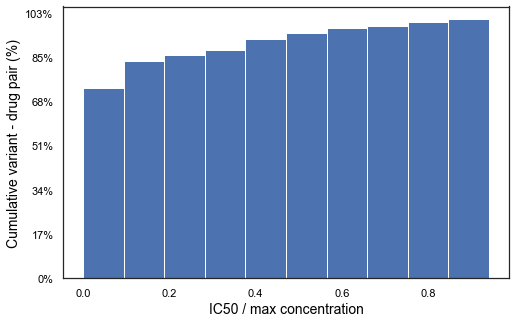

In [149]:
# best drug for each of our variant
import matplotlib.ticker as mtick
leads_df["IC50_ratio"] = leads_df.IC50 / leads_df.MAX_CONC

fig, ax = plt.subplots(figsize=(8, 5))
ax = leads_df["IC50_ratio"].plot.hist(cumulative=True)
ax.set_xlabel("IC50 / max concentration", fontsize=14);
ax.set_ylabel("Cumulative variant - drug pair (%)", fontsize=14);
ax.yaxis.set_major_formatter(mtick.PercentFormatter(leads_df.shape[0]))

fig.savefig(f"figures/bestdrug-var_IC50maxC_GDSC.pdf", format="pdf", dpi=fig.dpi)

In [150]:
#best_drug_df = pd.read_csv("data/significant_hgvs_GDSC12_IC50_bestdrugs.tsv", sep="\t", index_col=None)
#best_drug_df

In [151]:
dependency_vep_target_response_df[(dependency_vep_target_response_df.essentiality_annot == True) & \
                                 (dependency_vep_target_response_df.vep_annot == True) & \
                                 (dependency_vep_target_response_df["drug-gene_annot"] == True) & \
                                 (dependency_vep_target_response_df.drug_cell_in_GDSC == True) & \
                                 (dependency_vep_target_response_df["IC50<MAX_CONC"] == True) &\
                                (dependency_vep_target_response_df.best_drug_for_var == True)].\
sort_values('IC50')

var                       hgvs COSMIC_ID CELL_LINE_NAME    GENE  \
130206  p.E545K  ENST00000263967:c.1633G>A    906824         Ca-Ski  PIK3CA   
132748  p.E542K  ENST00000263967:c.1624G>A    907055         HGC-27  PIK3CA   
130186  p.E545K  ENST00000263967:c.1633G>A    908121     MDA-MB-361  PIK3CA   
20108   p.V600E  ENST00000288602:c.1799T>A    906844        DU-4475    BRAF   
130226  p.E545K  ENST00000263967:c.1633G>A    687514         ME-180  PIK3CA   
...         ...                        ...       ...            ...     ...   
22745   p.V600E  ENST00000288602:c.1799T>A    909747         SW1417    BRAF   
22731   p.V600E  ENST00000288602:c.1799T>A   1674021         SNU-C5    BRAF   
92479    p.G12C    ENST00000311936:c.34G>T    722046      NCI-H2122    KRAS   
93415    p.G12V    ENST00000311936:c.35G>T    909735          SNG-M    KRAS   
94054    p.G12A    ENST00000311936:c.35G>C    905964      RPMI-8226    KRAS   

                                     ctype        DRUG_NAME_response  \
130206        Squamous Cell Lung Carcinoma                Omipalisib   
132748                    Breast Carcinoma                Omipalisib   
130186        Squamous Cell Lung Carcinoma                Omipalisib   
20108                      Ewing's Sarcoma                Dabrafenib   
130226        Squamous Cell Lung Carcinoma                Omipalisib   
...                                    ...                       ...   
22745             Hepatocellular Carcinoma                  HG6-64-1   
22731             Hepatocellular Carcinoma                Dabrafenib   
92479   Esophageal Squamous Cell Carcinoma  KRAS (G12C) Inhibitor-12   
93415                 Colorectal Carcinoma  KRAS (G12C) Inhibitor-12   
94054                  Plasma Cell Myeloma  KRAS (G12C) Inhibitor-12   

             Transcript  essentiality_annot  vep_annot  drug-gene_annot  \
130206  ENST00000263967                True       True             True   
132748  ENST00000263967                True       True             True   
130186  ENST00000263967                True       True             True   
20108   ENST00000288602                True       True             True   
130226  ENST00000263967                True       True             True   
...                 ...                 ...        ...              ...   
22745   ENST00000288602                True       True             True   
22731   ENST00000288602                True       True             True   
92479   ENST00000311936                True       True             True   
93415   ENST00000311936                True       True             True   
94054   ENST00000311936                True       True             True   

        drug_cell_in_GDSC  IC50<MAX_CONC  best_drug_for_var    impact  \
130206               True           True               True  MODERATE   
132748               True           True               True  MODERATE   
130186               True           True               True  MODERATE   
20108                True           True               True  MODERATE   
130226               True           True               True  MODERATE   
...                   ...            ...                ...       ...   
22745                True           True               True  MODERATE   
22731                True           True               True  MODERATE   
92479                True           True               True  MODERATE   
93415                True           True               True  MODERATE   
94054                True           True               True  MODERATE   

       consequence_terms  cadd_phred polyphen_prediction sift_prediction  \
130206  missense_variant        31.0   probably_damaging     deleterious   
132748  missense_variant        31.0   probably_damaging     deleterious   
130186  missense_variant        31.0   probably_damaging     deleterious   
20108   missense_variant        30.0   probably_damaging     deleterious   
130226  missense_variant        31.0   p

# Conclusions and Next Steps
Summarize findings here